# Import

Import des données sans les tags.

Pour le calcul sur l'ensemble des données, on n'effectue que le TF-IDF qui donne des résultats similaires au CountVectorizer.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dataTF = pd.read_csv('TF-IDF.csv')
data = pd.read_csv('dataRaw.csv')

Aperçu :

In [2]:
data.head(5)

,Tags,TitleBody
0,['c#'],decimal double convert c opacity past use chan...
1,"['css', 'html']",percentage explorer parent collapse width chil...
2,"['.net', 'c#']",birthday base calculate age type birthday repr...
3,['c#'],c time calculate time like day display month v...
4,['html'],user determine page way string user server web...


### Nuage de mots

Affichage des mots sous forme de nuage, fonction

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def afficheNuage(listeMots):
    
    # Jointure des mots sous forme d'objet wordcloud
    long_string = ' '.join(list(listeMots))
    
    # Création du nuage
    wordcloud = WordCloud(background_color="white")
    
    # Affichage
    fig = plt.figure(figsize=(10, 6))
    wordcloud.generate(long_string)
    plt.imshow(wordcloud.to_image())
    plt.axis("off")
    plt.show()

Application de la fonction :

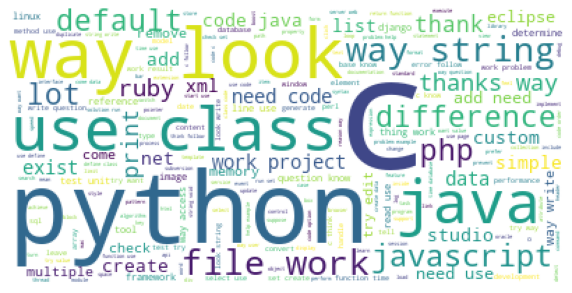

In [4]:
afficheNuage(data['TitleBody'].values)

# Non supervisé

### Bag of words

On recrée le dictionnaire qui correspond au corpus des mots uniques et on applique un :

In [5]:
from gensim.utils import simple_preprocess
from gensim import corpora

lignes = []
for i, x in data.iterrows():
    lignes.append(x['TitleBody'])

doc_tokenized = [simple_preprocess(doc, min_len=1) for doc in lignes]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
# print(BoW_corpus)

Affichage de la première ligne du corpus :

In [6]:
import nltk

print(nltk.word_tokenize(data['TitleBody'][0]))
print(len(nltk.word_tokenize(data['TitleBody'][0])))

['decimal', 'double', 'convert', 'c', 'opacity', 'past', 'use', 'change', 'code', 'fine', 'try', 'want', 'build', 'error', 'follow', 'control', 'work', 'project', 'application', 'form']
20


### LDA

Nombre de cluster que l'on souhaite effectuer, égal au nombre de tags du premier notebook.

In [7]:
N_TAGS = 10
N_CLUSTERS = N_TAGS
N_MOTS = 100

Création de la LDA :

In [8]:
import gensim

lda = gensim.models.LdaMulticore(BoW_corpus, num_topics=N_CLUSTERS, id2word=dictionary, passes=2, workers=2)

Affichage des sujets créés sous forme de nuages. Comme on a un poids associé à chaque mot pour chaque sujet, on duplique les mots autant de fois qu'il y a des poids (multipliés par mille de manière à obtenir un entier) afin de tracer le nuage de mots pondéré :

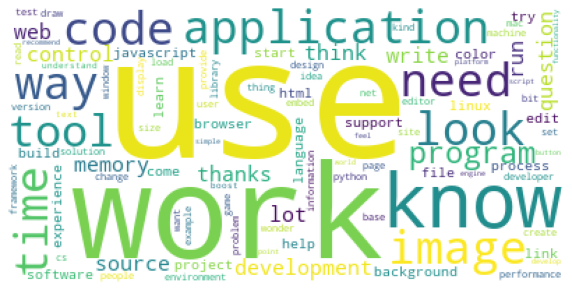

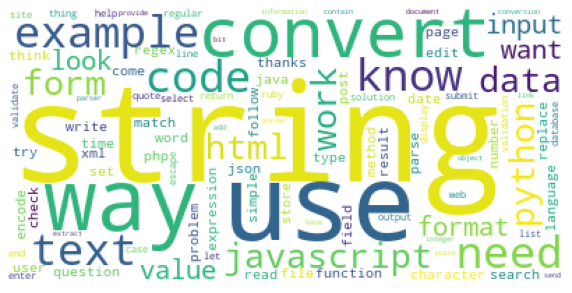

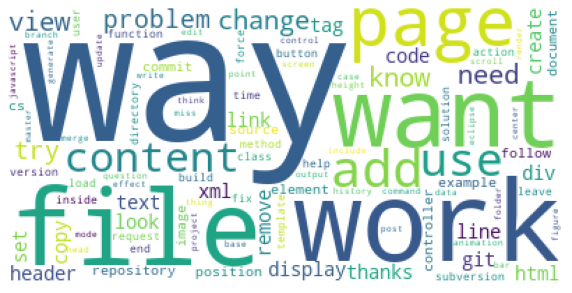

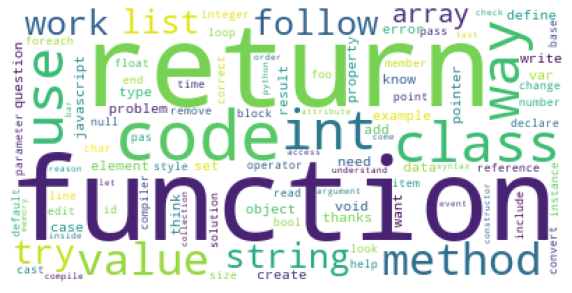

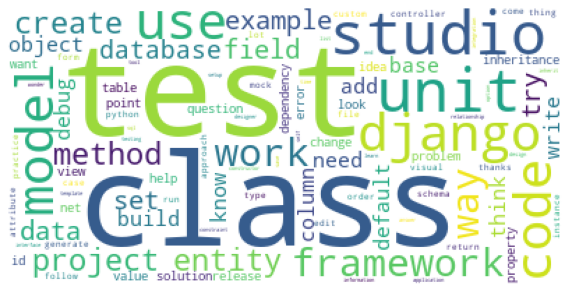

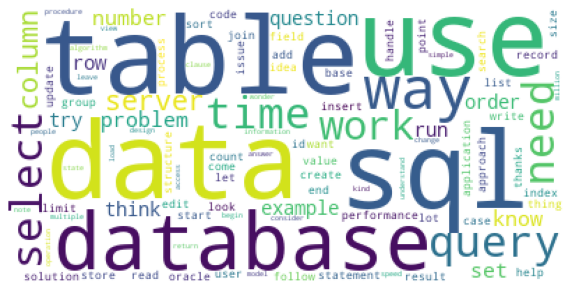

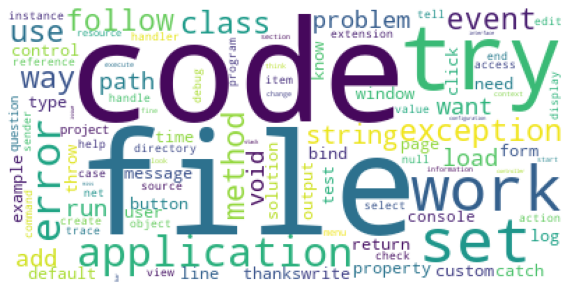

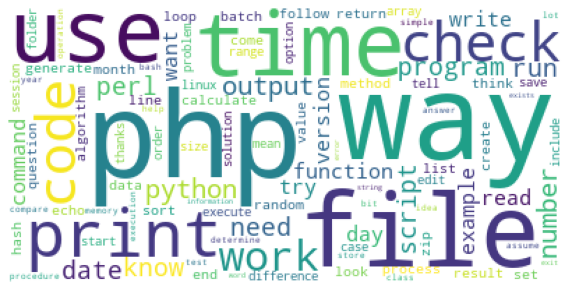

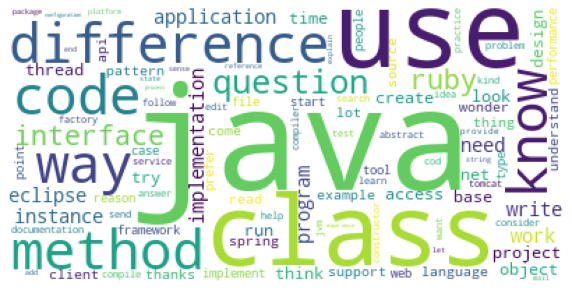

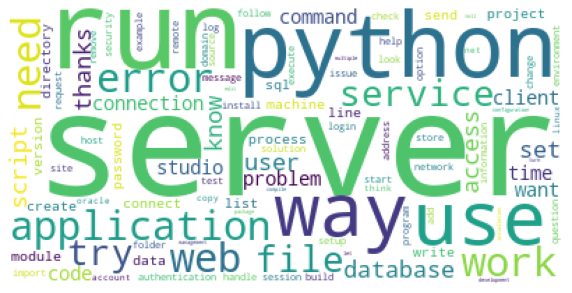

In [9]:
import re
import numpy as np

# On effectue une boucle sur chaque topic
for id, topic in lda.show_topics(formatted=True, num_topics=N_CLUSTERS, num_words=N_MOTS):
    
    # On souhaite extraire un vecteur de mots pondéré (répétés)
    motsTopics = []
    
    # On sépare les mots par des +
    motsPoids = topic.split('+')
    
    # Pour chaque paire mot/poids extrait ces valeurs
    for motpoids in motsPoids:
        
        # La répétition du mot
        poids = re.findall("\d+\.\d+", motpoids)
        poids = float(poids[0])
        poids = poids*1000
        
        # Le mot
        mot = re.findall("[a-z]+", motpoids)
        mot = mot[0]
        # print(mot)
        
        # On ajoute n fois le mot au corpus du sujet
        for i in np.arange(1, poids):
            motsTopics.append(mot)
    
    # On affiche finalement le nuage
    afficheNuage(motsPoids)

Cohérence :

In [10]:
"""from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprintcoh = CoherenceModel(model=lda, texts=proc_docs, dictionary = dictionary, coherence = "c_v")
coh_lda = coh.get_coherence()
print("Coherence Score:", coh_lda)"""

'from gensim import corpora, models\nfrom gensim.models import CoherenceModel\nfrom pprint import pprintcoh = CoherenceModel(model=lda, texts=proc_docs, dictionary = dictionary, coherence = "c_v")\ncoh_lda = coh.get_coherence()\nprint("Coherence Score:", coh_lda)'

Visualisation :

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore")

pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda, BoW_corpus, dictionary)
pyLDAvis.display(lda_viz)

### Kmeans

Fonctions :

In [12]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

try:
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

mpl.rcParams["figure.figsize"] = (9, 6)


def displayElbowKMEANS(data, kmin, kmax):
    X = data.values
    # Instantiate the clustering model and visualizer
    model = KMeans(random_state=0)
    visualizer = KElbowVisualizer(model, k=(kmin, kmax), timings=False)
    visualizer.fit(X)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data


def calculKMEANS(data, kopti):
    # Calcul opti
    X = data.values
    model = KMeans(kopti, random_state=0)

    # Affichage
    fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
    visualizer = SilhouetteVisualizer(model, ax=axes[0])
    visualizer.fit(X)    # Fit the data to the visualizer
    visualizer = InterclusterDistance(model, ax=axes[1])
    visualizer.fit(X)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

    # Affichage des moyennes par cluster
    etiquettes = model.labels_
    # return etiquettes

Standardisation des données :

In [13]:
from sklearn.preprocessing import StandardScaler

dataTFSTD = pd.DataFrame(StandardScaler().fit_transform(dataTF))

Calcul pour le nombre de clusters :

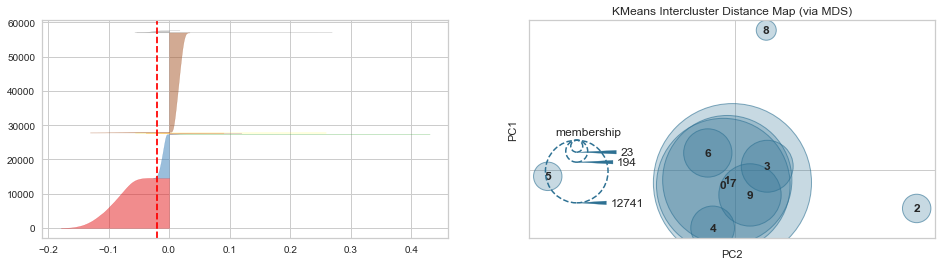

In [14]:
calculKMEANS(dataTFSTD, N_CLUSTERS)

# Supervisé

### Import avec tags

In [15]:
dataTFTags = pd.read_csv('TF-IDFTags.csv')
print(dataTFTags.shape[1])
print(dataTFTags.shape[1]-N_TAGS)
# dataTFTags.head(5)

3056
3046


### Folds validation croisée

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

nbOfSlices = 10
kf = KFold(n_splits=nbOfSlices, shuffle=False)
cv = RepeatedKFold(n_splits=nbOfSlices)

### Split du jeu de données

Fonction qui récupère automatiquement les bonnes colonnes dans les dataframes :

In [17]:
from sklearn.model_selection import train_test_split


def splitXYtags(dataWithTags, dataWithoutTags, N_TAGS):
    X = dataWithTags.iloc[:, 0:-N_TAGS]
    Y = dataWithTags.iloc[:, dataWithoutTags.shape[1]:]
    
    return train_test_split(X, Y, train_size=0.8, random_state=0)

### Random Forest

Fonction qui reprend le split (adapté à la manière dont sont découpées nos données) et le random forest :

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score


# Calcul de R2 sur la random forest
def randomForestMultiple(dataWithTags, dataWithoutTags, N_TAGS):
    
    # Split des données
    X_train, X_test, Y_train, Y_test = splitXYtags(dataWithTags, dataWithoutTags, N_TAGS)
    
    # Hyperparamètres
    parameters = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 30, 50]
    }

    # Création du modèle
    rf = RandomForestClassifier(random_state=0)
    grid_clf = GridSearchCV(rf, param_grid=parameters, cv=kf)
    multi_target_linear = MultiOutputClassifier(grid_clf)
    multi_target_linear.fit(X_train, Y_train)

    # Scores
    print(jaccard_score(Y_test, multi_target_linear.predict(X_test), average='macro'))
    print(jaccard_score(Y_test, multi_target_linear.predict(X_test), average='micro'))
    print(f1_score(Y_test, multi_target_linear.predict(X_test), average='macro'))
    print(f1_score(Y_test, multi_target_linear.predict(X_test), average='micro'))
    print()

Application de la random forest :

In [ ]:
randomForestMultiple(dataTFTags, dataTF, N_TAGS)

### Gradient Boosting

Même fonction pour le GB :

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


# Calcul de R2 sur la random forest
def gradientboostingMultiple(dataWithTags, dataWithoutTags, N_TAGS):
    
    # Split des données
    X_train, X_test, Y_train, Y_test = splitXYtags(dataWithTags, dataWithoutTags, N_TAGS)
    
    # Hyperparamètres
    parameters = {
        "n_estimators": [50, 100, 200],
        "max_depth": [1, 3, 5, None],
    }
    
    # Création du modèle
    gb = GradientBoostingClassifier(random_state=0)
    grid_clf = GridSearchCV(gb, param_grid=parameters, cv=kf)
    multi_target_linear = MultiOutputClassifier(grid_clf)
    multi_target_linear.fit(X_train, Y_train)
    
    # Scores
    print(jaccard_score(Y_test, multi_target_linear.predict(X_test), average='macro'))
    print(jaccard_score(Y_test, multi_target_linear.predict(X_test), average='micro'))
    print(f1_score(Y_test, multi_target_linear.predict(X_test), average='macro'))
    print(f1_score(Y_test, multi_target_linear.predict(X_test), average='micro'))
    print()

Application du GB :

In [ ]:
gradientboostingMultiple(dataTFTags, dataTF, N_TAGS)